# Projet Steganographie texte dans une image rbv

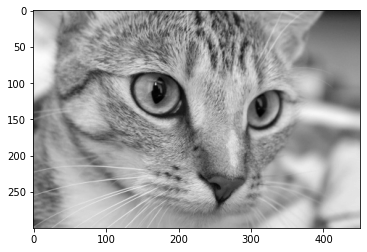

(300, 451)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

img = skimage.data.chelsea()
img = skimage.color.rgb2gray(img)
plt.imshow(img, 'gray')
plt.show()
print(img.shape)

## Etape 1